In [1]:
# Importing the libraries
import tqdm
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Load data from processed CSV

In [2]:
#Loading Data
data = pd.read_csv('/Users/pradyumn/Downloads/data_classes_reduced.csv')
data = data[data['emotion'].isin(['neu', 'ang', 'sad', 'hap'])]

# Define the features and labels
features_df_train = data.drop(['emotion', 'id'], axis=1)
labels = data['emotion']



#### Preprocessing

In [3]:
# Split the data into training and testing with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(features_df_train, labels, test_size=0.2, random_state=42)
texts_train = X_train['recognized_text'].apply(lambda x: eval(x)['text']).to_list()
texts_test = X_test['recognized_text'].apply(lambda x: eval(x)['text']).to_list()
X_train.drop('recognized_text', axis=1, inplace=True)
X_test.drop('recognized_text', axis=1, inplace=True)

In [4]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train+texts_test)

In [5]:
sequences_train = tokenizer.texts_to_sequences(texts_train)
max_length_train = max([len(seq) for seq in sequences_train])
padded_sequences = pad_sequences(sequences_train, maxlen=max_length_train)

sequences_val = tokenizer.texts_to_sequences(texts_test)
max_length = max([len(seq) for seq in sequences_val])
# Use the maximum sequence length from the training data for padding the validation sequences
padded_sequences_val = pad_sequences(sequences_val, maxlen=max_length_train)


In [6]:
# Encode the string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [7]:
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])



In [8]:
# Create DataLoader for training and testing
train_dataset = CustomDataset(padded_sequences, y_train_encoded)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(padded_sequences_val, y_test_encoded)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
hidden_dim = 128
output_dim = len(label_encoder.classes_)
num_filters = 100
filter_sizes = [2, 3, 4, 5]
dropout = 0.5

criterion = nn.CrossEntropyLoss()


In [9]:
# Validation function
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return val_loss, accuracy

In [10]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [11]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = output[:, -1, :]
        output = self.fc(output)
        return output
    
GRUmodel = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim)
    
# check if model is already trained
if os.path.exists('gru_model.pt'):
    GRUmodel.load_state_dict(torch.load('gru_model.pt'))

else:
    # Initialize EarlyStopping instance
    early_stopping = EarlyStopping(patience=3, verbose=True)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # Define loss function and optimizer
    optimizer = optim.Adam(GRUmodel.parameters())

    # Training loop
    for epoch in range(10):
        GRUmodel.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = GRUmodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        val_loss, val_accuracy = validate(GRUmodel, val_loader, criterion)
        print(f"Epoch {epoch+1}/{10}, Training Loss: {running_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Check if validation loss is decreasing
        early_stopping(val_loss, GRUmodel)
        
        if early_stopping.early_stop:
            stop_epoch = epoch
            print("Early stopping")
            break

    # Save the model
    GRUmodel.load_state_dict(torch.load('checkpoint.pt'))
    torch.save(GRUmodel.state_dict(), 'gru_model.pt')
    
    

Epoch 1/10, Training Loss: 156.48506951332092, Validation Loss: 36.1934888958931, Validation Accuracy: 0.49949031600407745
Validation loss decreased (inf --> 36.193489).  Saving model ...
Epoch 2/10, Training Loss: 123.60378617048264, Validation Loss: 33.20502769947052, Validation Accuracy: 0.5443425076452599
Validation loss decreased (36.193489 --> 33.205028).  Saving model ...
Epoch 3/10, Training Loss: 94.08741101622581, Validation Loss: 32.20336103439331, Validation Accuracy: 0.5769622833843018
Validation loss decreased (33.205028 --> 32.203361).  Saving model ...
Epoch 4/10, Training Loss: 68.1468917131424, Validation Loss: 32.86236506700516, Validation Accuracy: 0.5932721712538226
EarlyStopping counter: 1 out of 3
Epoch 5/10, Training Loss: 48.6672545671463, Validation Loss: 35.723844826221466, Validation Accuracy: 0.6085626911314985
EarlyStopping counter: 2 out of 3
Epoch 6/10, Training Loss: 37.04800011962652, Validation Loss: 38.38874262571335, Validation Accuracy: 0.601427115

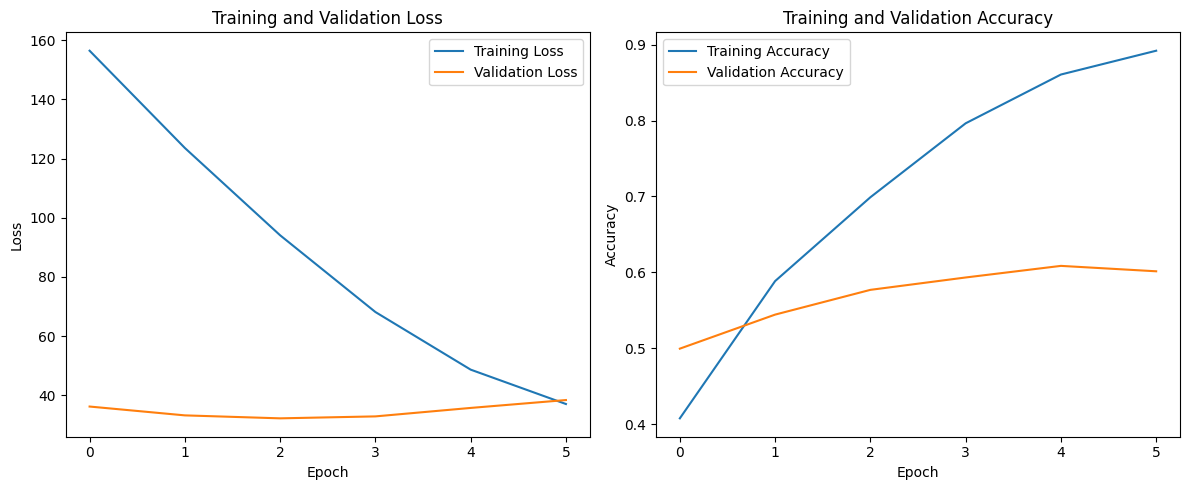

In [12]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs = range(0, stop_epoch+1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()    

GRU Model 
Accuracy - 60.142%


In [13]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(CNNModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])   
        # Fully connected layer
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        # Dropout
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        # x: [batch_size, seq_len]
        # Add channel dimension
        x = x.unsqueeze(1)  # [batch_size, 1, seq_len]
        # Apply embedding
        embedded = self.embedding(x)  # [batch_size, 1, seq_len, embedding_dim]
        # Convolutional and pooling layers
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]  # [(batch_size, num_filters, seq_len - filter_sizes[n] + 1)]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  # [(batch_size, num_filters)]
        # Concatenate pooled outputs
        cat = self.dropout(torch.cat(pooled, dim=1))  # [batch_size, len(filter_sizes) * num_filters]
        # Fully connected layer
        output = self.fc(cat)  # [batch_size, output_dim]
        return output
    
CNNmodel = CNNModel(vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout)
if(os.path.exists('cnn_model.pt')):
    CNNmodel.load_state_dict(torch.load('cnn_model.pt'))
else:
    # Initialize EarlyStopping instance
    early_stopping = EarlyStopping(patience=3, verbose=True)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    optimizer = optim.Adam(CNNmodel.parameters())

    # Training loop
    for epoch in range(10):
        CNNmodel.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = CNNmodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        val_loss, val_accuracy = validate(CNNmodel, val_loader, criterion)
        print(f"Epoch {epoch+1}/{10}, Training Loss: {running_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        # Check if validation loss is decreasing
        early_stopping(val_loss, CNNmodel)
        
        if early_stopping.early_stop:
            stop_epoch = epoch
            print("Early stopping")
            break
    # Save the model
    CNNmodel.load_state_dict(torch.load('checkpoint.pt'))
    torch.save(CNNmodel.state_dict(), 'cnn_model.pt')
    


Epoch 1/10, Training Loss: 161.8239313364029, Validation Loss: 34.751427948474884, Validation Accuracy: 0.5198776758409785
Validation loss decreased (inf --> 34.751428).  Saving model ...
Epoch 2/10, Training Loss: 116.80722683668137, Validation Loss: 32.89653158187866, Validation Accuracy: 0.5565749235474006
Validation loss decreased (34.751428 --> 32.896532).  Saving model ...
Epoch 3/10, Training Loss: 94.49326717853546, Validation Loss: 31.490190505981445, Validation Accuracy: 0.5983690112130479
Validation loss decreased (32.896532 --> 31.490191).  Saving model ...
Epoch 4/10, Training Loss: 77.21538814902306, Validation Loss: 32.75083065032959, Validation Accuracy: 0.5851172273190621
EarlyStopping counter: 1 out of 3
Epoch 5/10, Training Loss: 67.65065875649452, Validation Loss: 34.1779659986496, Validation Accuracy: 0.5861365953109072
EarlyStopping counter: 2 out of 3
Epoch 6/10, Training Loss: 59.7613742351532, Validation Loss: 34.721987783908844, Validation Accuracy: 0.61467889

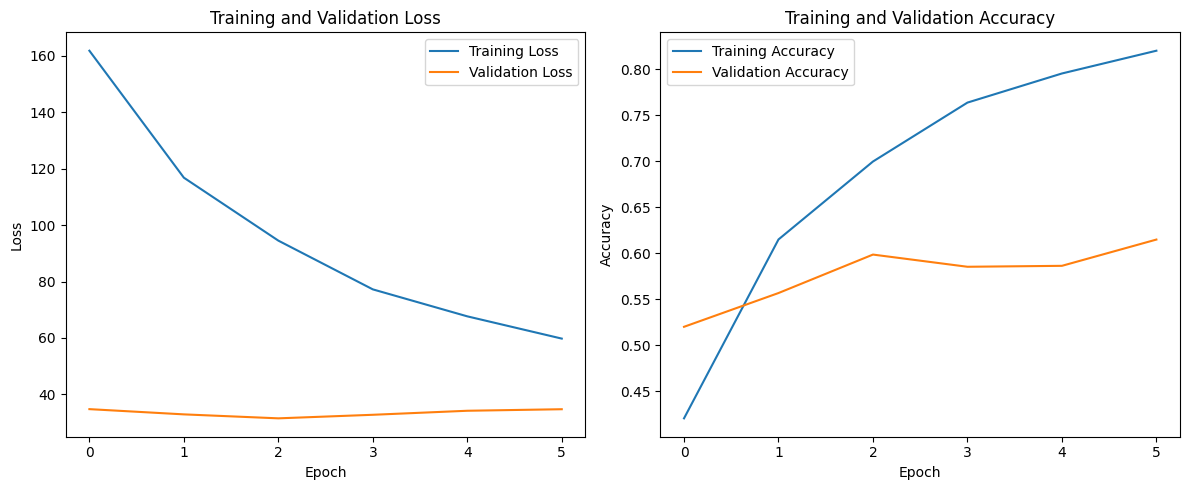

In [14]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs = range(0, stop_epoch+1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()    

CNN Model Accuracy - 61.467%

In [15]:
# Define the Bi-GRU model
class BiGRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiGRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru_forward = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.gru_backward = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Concatenate forward and backward hidden states

    def forward(self, x):
        embedded = self.embedding(x)
        output_forward, _ = self.gru_forward(embedded)
        output_backward, _ = self.gru_backward(embedded.flip(1))  # Reverse the input sequence
        output = torch.cat((output_forward[:, -1, :], output_backward[:, -1, :]), dim=1)  # Concatenate outputs
        output = self.fc(output)
        return output

BiGRUmodel = BiGRUModel(vocab_size, embedding_dim, hidden_dim, output_dim)

if(os.path.exists('bi_gru_model.pt')):
    BiGRUmodel.load_state_dict(torch.load('bi_gru_model.pt'))
else:
    # Initialize EarlyStopping instance
    early_stopping = EarlyStopping(patience=3, verbose=True)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    optimizer = optim.Adam(BiGRUmodel.parameters())
    
    # Training loop
    for epoch in range(10):
        BiGRUmodel.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = BiGRUmodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        val_loss, val_accuracy = validate(BiGRUmodel, val_loader, criterion)
        print(f"Epoch {epoch+1}/{10}, Training Loss: {running_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
        train_losses.append(running_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Check if validation loss is decreasing
        early_stopping(val_loss, BiGRUmodel)
        
        if early_stopping.early_stop:
            stop_epoch = epoch
            print("Early stopping")
            break

    # Save the model
    BiGRUmodel.load_state_dict(torch.load('checkpoint.pt'))
    torch.save(BiGRUmodel.state_dict(), 'bi_gru_model.pt')
    # Plotting
    epochs = range(0, stop_epoch+1)



Epoch 1/10, Training Loss: 157.30712378025055, Validation Loss: 36.727247297763824, Validation Accuracy: 0.47604485219164117
Validation loss decreased (inf --> 36.727247).  Saving model ...
Epoch 2/10, Training Loss: 124.67066222429276, Validation Loss: 33.017953991889954, Validation Accuracy: 0.5667686034658511
Validation loss decreased (36.727247 --> 33.017954).  Saving model ...
Epoch 3/10, Training Loss: 93.33484229445457, Validation Loss: 32.65638291835785, Validation Accuracy: 0.5677879714576962
Validation loss decreased (33.017954 --> 32.656383).  Saving model ...
Epoch 4/10, Training Loss: 64.70396164059639, Validation Loss: 34.139939963817596, Validation Accuracy: 0.5902140672782875
EarlyStopping counter: 1 out of 3
Epoch 5/10, Training Loss: 44.49927078187466, Validation Loss: 36.22483593225479, Validation Accuracy: 0.5861365953109072
EarlyStopping counter: 2 out of 3
Epoch 6/10, Training Loss: 33.1290347725153, Validation Loss: 39.36301499605179, Validation Accuracy: 0.60550

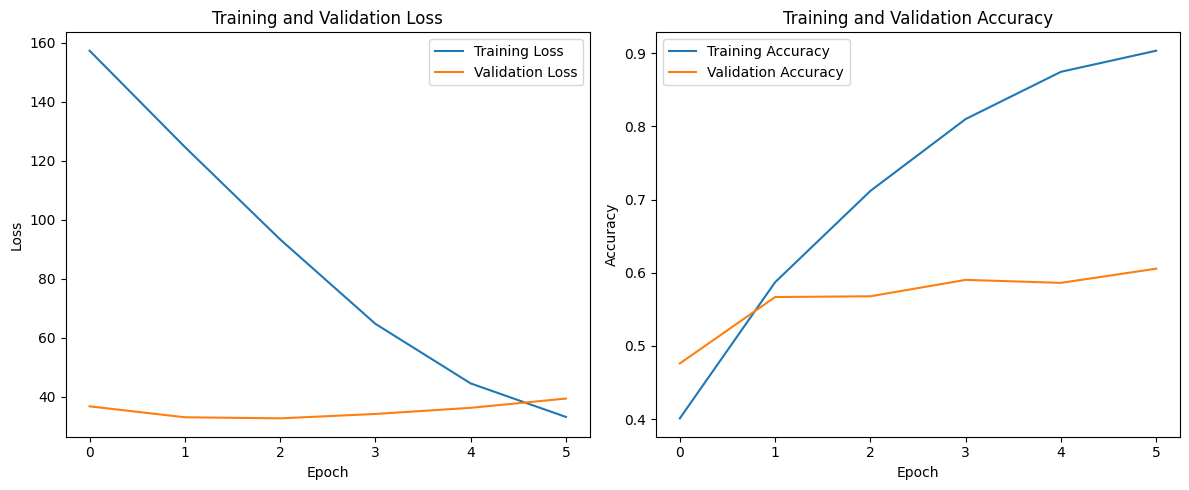

In [16]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs = range(0, stop_epoch+1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()    

Bi-GRU Model Accuracy - 60.55%

As seen from the graph above, all models perform similarly. However the GRU model has the highest accuracy at 61.46%.
This will be the model used along with MLP